In [36]:
import os
import matplotlib.pyplot as plt
import potion.visualization.notebook_utils as nu
from importlib import reload

In [37]:
reload(nu)

<module 'potion.visualization.notebook_utils' from '/home/matteo/policy-optimization/potion/visualization/notebook_utils.py'>

# LQG safe

seeds = [2030, 4473, 5759, 5756, 4146, 1428, 9723, 3212, 8589, 1971]

In [22]:
os.chdir('/home/matteo/policy-optimization/results/lqg_safe')

SEPGMI: -91.724603 +- 0.221551
SEPGBUD: -22.180058 +- 0.362868
ADASTEP: -103.767587 +- 0.206888


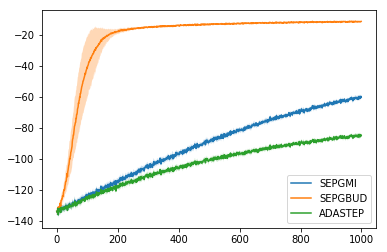

SEPGMI: 0.790785 +- 0.000150
SEPGBUD: 0.129274 +- 0.003451
ADASTEP: 1.000000 +- 0.000000


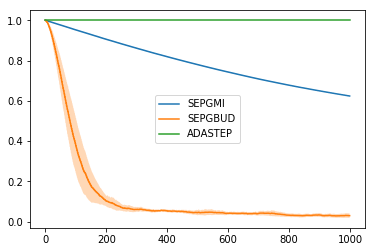

In [23]:
nu.compare('lqgd', 
           ['SEPGMI', 'SEPGBUD', 'ADASTEP'], 
           keys=['UPerf', 'Exploration'], 
           separate=False,
           conf=.95,
           nrows=1000)

In [24]:
nu.save_csv('lqgd', 'SEPGMI', 'UPerf', path='/home/matteo/budget_paper/neurips19/plots', conf=.95, rows=1000)
nu.save_csv('lqgd', 'SEPGBUD', 'UPerf', path='/home/matteo/budget_paper/neurips19/plots', conf=.95, rows=1000)
nu.save_csv('lqgd', 'ADASTEP', 'UPerf', path='/home/matteo/budget_paper/neurips19/plots', conf=.95, rows=1000)
nu.save_csv('lqgd', 'SEPGMI', 'Exploration', path='/home/matteo/budget_paper/neurips19/plots', conf=.95, rows=1000)
nu.save_csv('lqgd', 'SEPGBUD', 'Exploration', path='/home/matteo/budget_paper/neurips19/plots', conf=.95, rows=1000)
nu.save_csv('lqgd', 'ADASTEP', 'Exploration', path='/home/matteo/budget_paper/neurips19/plots', conf=.95, rows=1000)

# Cartpole safe

seeds = [2030, 4473, 5759, 5756, 4146]

In [25]:
os.chdir('/home/matteo/policy-optimization/results/cartpole_safe')

HIGHSAFE10: 85.709852 +- 0.406732
HIGHSAFE100: 209.293377 +- 1.821045
HIGHSAFE1000: 617.343585 +- 9.831168


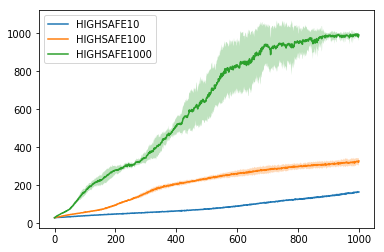

HIGHSAFE10: 2.454276 +- 0.012485
HIGHSAFE100: 1.600544 +- 0.020286
HIGHSAFE1000: 2.376774 +- 0.069385


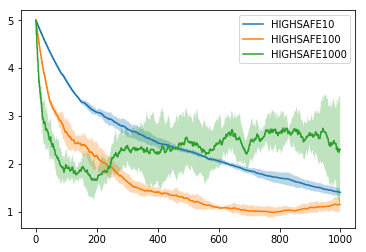

In [27]:
nu.compare('contcartpole', 
           ['HIGHSAFE10', 'HIGHSAFE100', 'HIGHSAFE1000'], 
           keys=['UPerf', 'Exploration'], 
           separate=False,
           conf=.95,
           nrows=1000)

In [28]:
nu.save_csv('contcartpole', 'HIGHSAFE10', 'UPerf', path='/home/matteo/budget_paper/neurips19/plots', conf=.95, rows=1000)
nu.save_csv('contcartpole', 'HIGHSAFE100', 'UPerf', path='/home/matteo/budget_paper/neurips19/plots', conf=.95, rows=1000)
nu.save_csv('contcartpole', 'HIGHSAFE1000', 'UPerf', path='/home/matteo/budget_paper/neurips19/plots', conf=.95, rows=1000)
nu.save_csv('contcartpole', 'HIGHSAFE10', 'Exploration', path='/home/matteo/budget_paper/neurips19/plots', conf=.95, rows=1000)
nu.save_csv('contcartpole', 'HIGHSAFE100', 'Exploration', path='/home/matteo/budget_paper/neurips19/plots', conf=.95, rows=1000)
nu.save_csv('contcartpole', 'HIGHSAFE1000', 'Exploration', path='/home/matteo/budget_paper/neurips19/plots', conf=.95, rows=1000)

# Minigolf

In [20]:
os.chdir('/home/matteo/policy-optimization/results/sepgmini')

sepg: -3.561389 +- 0.030102
mepg1x1: -1.858789 +- 0.025004


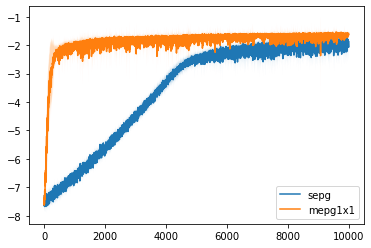

sepg: 0.117472 +- 0.001248
mepg1x1: 0.057135 +- 0.003757


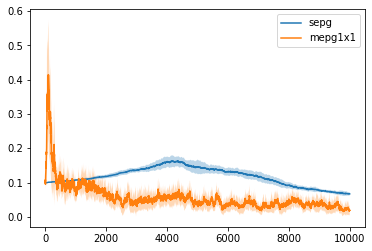

sepg: 2.878423 +- 0.121020
mepg1x1: 6.869979 +- 0.152545


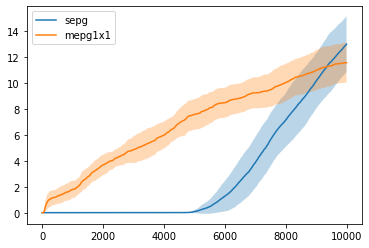

In [42]:
nu.compare('minigolf', 
           ['sepg', 'mepg1x1'],
            #'mepg1x1', 'mepg1x01', 'mepg1x001',
            #'mepg01x1', 'mepg01x01', 'mepg01x001',
            #'mepg001x1', 'mepg001x01', 'mepg001x001',], 
           keys=['UPerf', 'Exploration', 'CumInfo'], 
           rows=10000,
           roll=1)